<a href="https://colab.research.google.com/github/vandana10/deeplearning-using-pytorch/blob/main/neural_network_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural network classification with PyTorch
predicting whether something is one thing or another

## 1. Make classification data and get it ready

In [29]:
import sklearn

In [30]:
from sklearn.datasets import make_circles

n_samples = 1000

X,Y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

len(X)

1000

In [31]:
print(f"print first 5 samples of X:{X[:5]}")
print(f"print first 5 samples of Y:{Y[:5]}")

print first 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
print first 5 samples of Y:[1 1 1 1 0]


In [32]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":Y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


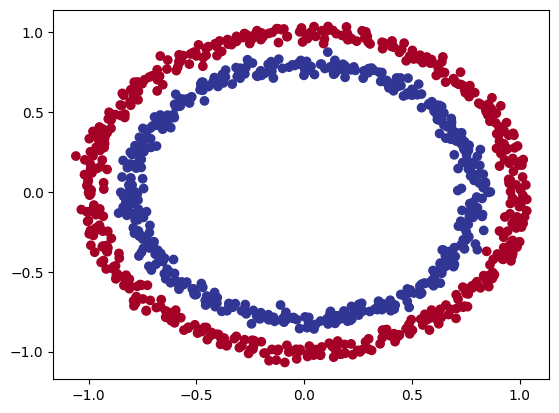

In [33]:
#visialise
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu)

Note: the data we ar eworking with is called as Toy dataset

## Check input and output shapes

In [34]:
X.shape, Y.shape

((1000, 2), (1000,))

In [35]:
X_sample = X[0]
Y_sample = Y[0]

print(f"Values for one sample of X: {X_sample} and the same for Y: {Y_sample}")
print(f"Shape of one sample of X: {X_sample.shape} and the same for Y: {Y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for Y: 1
Shape of one sample of X: (2,) and the same for Y: ()


## Turn data into tensors and create train and test splits

In [36]:
import torch


In [37]:
type(X)

numpy.ndarray

In [38]:
type(X)

numpy.ndarray

In [39]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

## 1. Split data into training and test

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2, #20% is test and 80% train
                                                    random_state=42)


In [42]:
len(X_train) , len(X_test)

(800, 200)

## 2. Building a model

Lets build a model to classify our blue and red dots

To do so, we want to:
1. Set up device agnostic code
2. Construct a model (by subclassing nn.module)
3. Define a loss function and optimiser
4. Create a training and test loop

In [43]:
import torch
from torch import nn

now lets create a model:
1. Subclasses nn.module
2. create 2 nn.linear() layers that are capable of handling the shapes of our data
3. define a forward() method that outlines the forward pass(or forward computation)
4. Instantiate an instance of our model class and send it to the target device


In [44]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))




In [45]:
model_0 = CircleModelV0()

In [46]:
#Make predictions
with torch.inference_mode():
  untrained_preds = model_0(torch.from_numpy(X_test).float())

print(f"Lenght of predictions: {len(untrained_preds)}, shape of predcitions : {untrained_preds.shape}")
print(f"\nLenght of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 labels: {Y_test[:10]}")

Lenght of predictions: 200, shape of predcitions : torch.Size([200, 1])

Lenght of test samples: 200, shape: (200, 2)

First 10 predictions: tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]])

First 10 labels: [1 0 1 0 1 1 0 0 1 0]


### 2.1 Set up loss functions and optimiser

which loss function or optimiser should you use?

For regression: MAE or MSE (mean abs error or mean squared error)

For classification: Binary cross entropy or categorial cross entropy

In [47]:
loss_fn = nn.BCEWithLogitsLoss() #has in-built sigmoid activation function

optimiser = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)


In [48]:
#Calc accuracy- out of 100 examples, what % does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## Train our model

1. Forward pass
2. Calc the loss
3. Optimiser zero grad
4. Loss backward(back propagation)
5. Optimiser (gradient descent)

### Going from raw logits -> Prediction proabilities -> prediction lables

Model outputa raw **logits**

Need to convert them into prediction proablilites by passing them into **Activation functions** (eg, sigmoid for binary classification and softmax for multiclass classification)

then from predcition proablities to lables, we can either round them or take argmax()

In [49]:
#View the first 5 outputs of forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(torch.from_numpy(X_test).float())
y_logits[:5]



tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])

In [50]:
#Use sigmoid activation fn
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs[:5]

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

For our predcition proability values, we need to perform a range style rounding on them:
1. y_preds_probs >= 0.5 , y=1 (class 1)
2. y_preds_probs < 0.5, y=0 (class 0)

In [51]:
#Find the prediction labels
y_preds = torch.round(y_preds_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(torch.from_numpy(X_test).float())))

#print(torch.eq(y_preds, y_pred_labels))

#y_preds.squeeze()

###Build a training and testing loop

In [52]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(torch.from_numpy(X_train).float()).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) #turns logits -> pred probs -> pred labels

  # nn.BCEWithLogitsLoss expects logits as input
  #loss = loss_fn(torch.sigmoid(y_logits),
  #                Y_train)
  loss = loss_fn(y_logits,
                 torch.from_numpy(Y_train).float())

  acc = accuracy_fn(y_true=torch.from_numpy(Y_train),
                    y_pred=y_preds)

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(torch.from_numpy(X_test).float()).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        torch.from_numpy(Y_test).float())
    test_acc = accuracy_fn(y_true=torch.from_numpy(Y_test),
                           y_pred=test_preds)

  #print
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")




Epoch: 0 | Loss: 0.69569 | Acc: 50.00000% | Test Loss: 0.69739 | Test Acc: 50.00000%
Epoch: 100 | Loss: 0.69405 | Acc: 50.00000% | Test Loss: 0.69622 | Test Acc: 50.00000%
Epoch: 200 | Loss: 0.69344 | Acc: 45.87500% | Test Loss: 0.69587 | Test Acc: 47.00000%
Epoch: 300 | Loss: 0.69322 | Acc: 49.12500% | Test Loss: 0.69577 | Test Acc: 47.00000%
Epoch: 400 | Loss: 0.69312 | Acc: 49.00000% | Test Loss: 0.69573 | Test Acc: 47.00000%
Epoch: 500 | Loss: 0.69308 | Acc: 50.12500% | Test Loss: 0.69569 | Test Acc: 46.50000%
Epoch: 600 | Loss: 0.69306 | Acc: 50.25000% | Test Loss: 0.69564 | Test Acc: 46.00000%
Epoch: 700 | Loss: 0.69305 | Acc: 50.25000% | Test Loss: 0.69559 | Test Acc: 46.00000%
Epoch: 800 | Loss: 0.69304 | Acc: 50.75000% | Test Loss: 0.69554 | Test Acc: 46.50000%
Epoch: 900 | Loss: 0.69303 | Acc: 50.50000% | Test Loss: 0.69548 | Test Acc: 46.50000%


## Make predctions and evaluate the model

From the metrics it looks like it isnt learning anything

In [53]:
import requests
from pathlib import Path

#Download helper functions from learn pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists


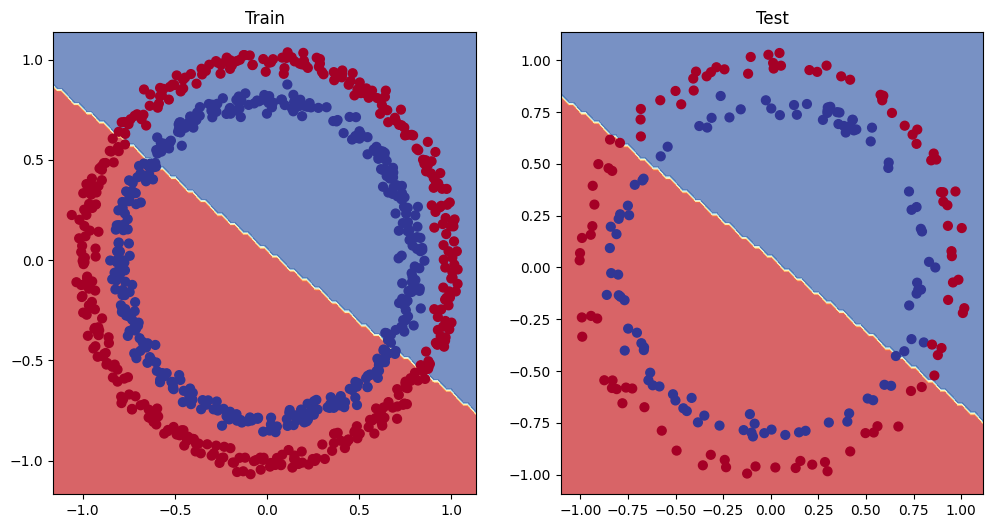

In [54]:
# plot decision boundary of the model
from helper_functions import plot_predictions, plot_decision_boundary

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train_tensor, Y_train_tensor)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test_tensor, Y_test_tensor)

## Improving our model(from a model perspective)

* add more layers
* add more hidden units (from 5 to 10 hidden units)
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

these options are all from a model's prespective.

**Hyperparameters** - values which we can change

Lets do this by:
1. add more hidden units: 5 -> 10
2. Increase no of layers: 2- > 3
3. Increase no pf epocs to 1000

In [56]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
#ceate a loss fn
loss_fn = nn.BCEWithLogitsLoss()

#create an optimiser
optimiser = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)


In [61]:
torch.manual_seed(42)

epochs = 1000


for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(torch.from_numpy(X_train).float()).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, torch.from_numpy(Y_train).float())
  acc = accuracy_fn(y_true=torch.from_numpy(Y_train),
                    y_pred=y_preds)

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(torch.from_numpy(X_test).float()).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,torch.from_numpy(Y_test).float())
    test_acc = accuracy_fn(y_true=torch.from_numpy(Y_test),
                           y_pred=test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")

Epoch: 0 | Loss: 0.69395 | Acc: 50.87500% | Test Loss: 0.69261 | Test Acc: 51.00000%
Epoch: 100 | Loss: 0.69392 | Acc: 50.50000% | Test Loss: 0.69261 | Test Acc: 51.00000%
Epoch: 200 | Loss: 0.69389 | Acc: 50.62500% | Test Loss: 0.69262 | Test Acc: 50.50000%
Epoch: 300 | Loss: 0.69386 | Acc: 50.62500% | Test Loss: 0.69263 | Test Acc: 50.50000%
Epoch: 400 | Loss: 0.69383 | Acc: 50.62500% | Test Loss: 0.69263 | Test Acc: 51.00000%
Epoch: 500 | Loss: 0.69381 | Acc: 50.75000% | Test Loss: 0.69264 | Test Acc: 50.50000%
Epoch: 600 | Loss: 0.69378 | Acc: 50.62500% | Test Loss: 0.69265 | Test Acc: 51.00000%
Epoch: 700 | Loss: 0.69376 | Acc: 50.25000% | Test Loss: 0.69266 | Test Acc: 51.00000%
Epoch: 800 | Loss: 0.69373 | Acc: 50.00000% | Test Loss: 0.69267 | Test Acc: 50.50000%
Epoch: 900 | Loss: 0.69371 | Acc: 49.87500% | Test Loss: 0.69268 | Test Acc: 50.50000%


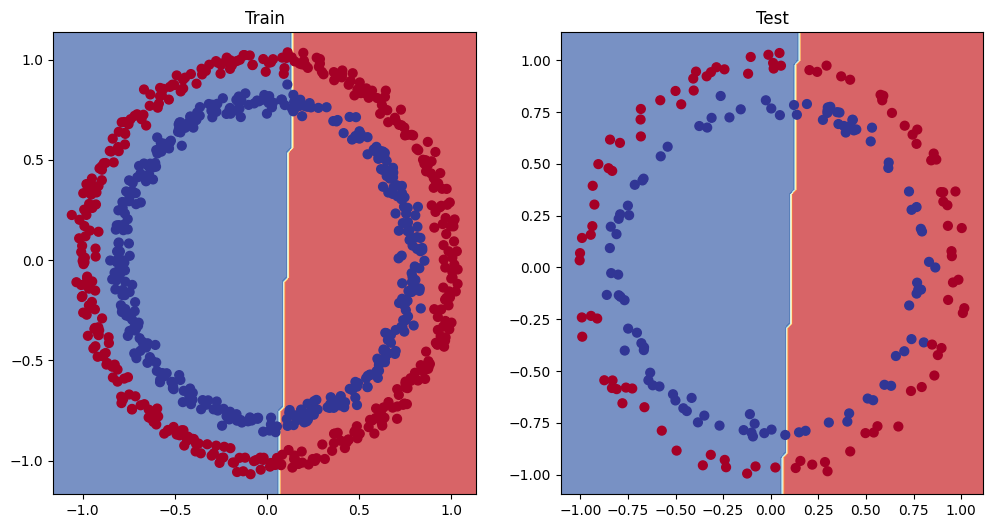

In [62]:
#plot the decison boundary

from helper_functions import plot_predictions, plot_decision_boundary

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train_tensor, Y_train_tensor)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test_tensor, Y_test_tensor)

### Prepaparing data to see if our model can fit a straight line

one way to troubleshoot a peoblem is to test out a smaller problem

In [64]:
#Create some data
w = 0.7
b = 0.3
start = 0
end =1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
Y_regression = w*X_regression + b

print(len(X_regression))
print(len(Y_regression))
X_regression[:5], Y_regression[:5]

100
100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [65]:
train_split = int(0.8*len(X_regression))

X_train_reg = X_regression[:train_split]
Y_train_reg = Y_regression[:train_split]

X_test_reg = X_regression[train_split:]
Y_test_reg = Y_regression[train_split:]

len(X_train_reg), len(Y_train_reg), len(X_test_reg), len(Y_test_reg)

(80, 80, 20, 20)

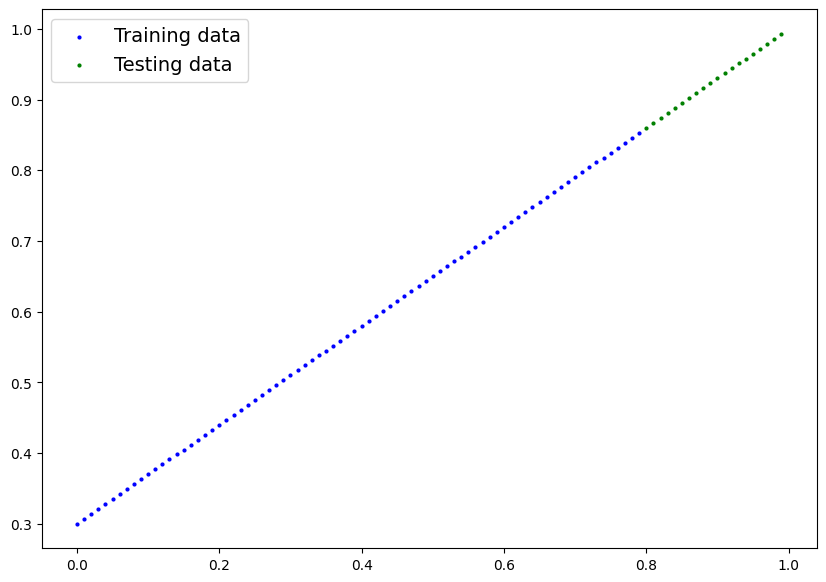

In [66]:
plot_predictions(train_data=X_train_reg,
                 train_labels=Y_train_reg,
                 test_data=X_test_reg,
                 test_labels=Y_test_reg,
                 predictions=None)

####Adjust model_1 to fit a straight line


In [68]:
#same arch as model_1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [78]:
#loss
loss_fn = nn.L1Loss()

#optimiser
optimiser = torch.optim.SGD(params = model_2.parameters(),
                            lr=0.01)

In [84]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_2.train()

  y_preds = model_2(X_train_reg.float())

  loss = loss_fn(y_preds, Y_train_reg.float())

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  model_2.eval()
  with torch.inference_mode():
    test_preds = model_2(X_test_reg.float()).squeeze()
    test_loss = loss_fn(test_preds, Y_test_reg.float())
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 | Loss: 0.13824 | Test Loss: 0.34049
Epoch: 100 | Loss: 0.02651 | Test Loss: 0.06497
Epoch: 200 | Loss: 0.01493 | Test Loss: 0.05277
Epoch: 300 | Loss: 0.00943 | Test Loss: 0.05786
Epoch: 400 | Loss: 0.01293 | Test Loss: 0.05724
Epoch: 500 | Loss: 0.01346 | Test Loss: 0.05715
Epoch: 600 | Loss: 0.01363 | Test Loss: 0.05651
Epoch: 700 | Loss: 0.01278 | Test Loss: 0.05536
Epoch: 800 | Loss: 0.01303 | Test Loss: 0.05583
Epoch: 900 | Loss: 0.01255 | Test Loss: 0.05546


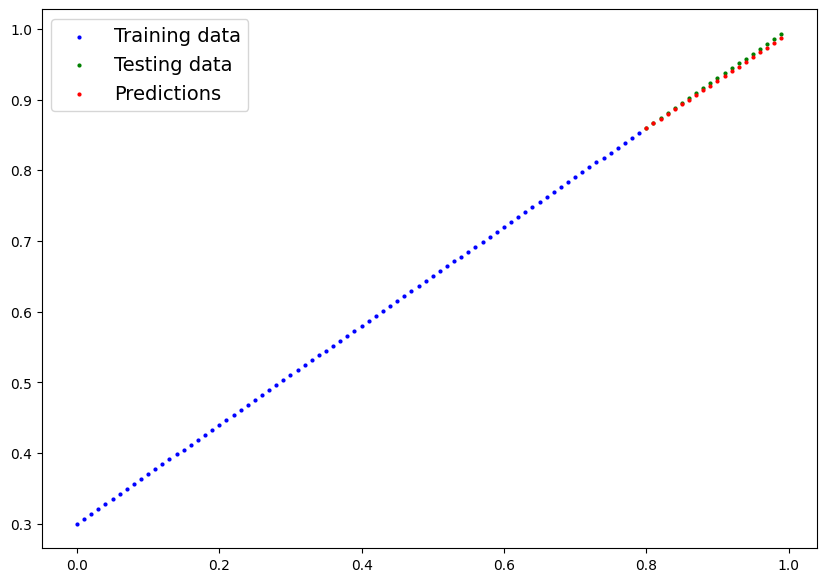

In [85]:
model_2.eval()

with torch.inference_mode():
  test_preds = model_2(X_test_reg.float()).squeeze()

plot_predictions(train_data=X_train_reg,
                 train_labels=Y_train_reg,
                 test_data=X_test_reg,
                 test_labels=Y_test_reg,
                 predictions=test_preds)

###Missing piece: Non linearity

What patterns could you draw if you were given an infinite amount of straight and non straight line?

or in machine learning terms, an infinite(but really it is finite) of linear and non linear functions?

### Recreating non linear data (red and blue circles)

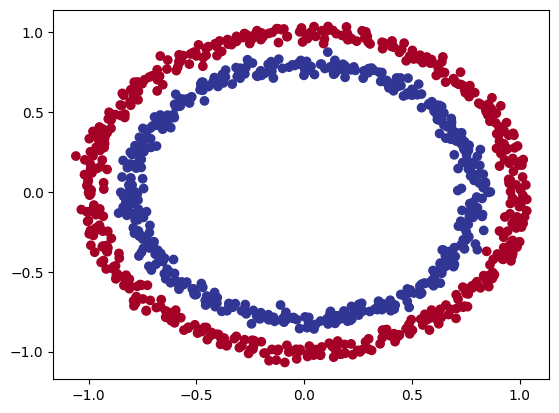

In [88]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import torch

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise = 0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [89]:
#Split data

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(Y_train), len(Y_test)


(800, 200, 800, 200)

##Build a model with non linearity

In [91]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self_layer_1 = nn.Linear(in_features=2, out_features=10)
    self_layer_2 = nn.Linear(in_features=10, out_features=10)
    self_layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #non linear activation fn -> put it in each layer

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
model_3

CircleModelV2(
  (relu): ReLU()
)